In [152]:
import pandas as pd
import numpy as np

import geopandas as gpd
import geopandas.tools as gdp_tools
from shapely.geometry import shape, Point, Polygon
import fiona

import json

In [153]:
DATA_LOC ='./data/'

In [154]:
#file = DATA_LOC + 'Basisdata_0000_Norge_25833_N2000Kartdata_FGDB/Basisdata_0000_Norge_25833_N2000Kartdata_FGDB.gdb'
file = DATA_LOC + 'Basisdata_0000_Norge_25833_N2000Kartdata_FGDB_3_9_2019/Basisdata_0000_Norge_25833_N2000Kartdata_FGDB.gdb'

for i, name in enumerate(fiona.listlayers(file)):
       print(name)
       if name == 'N2000_AdministrativeOmråder_omrade':
           with fiona.open(file, layer=i) as layer:
              for feature in layer:
                 objtype = (feature['properties']['objtype'])
                 if objtype != 'Kommune':
                    print(objtype)

N2000_Samferdsel_senterlinje
N2000_Arealdekke_omrade
N2000_Arealdekke_grense
N2000_Arealdekke_senterlinje
N2000_AdministrativeOmråder_grense
N2000_Høyde_senterlinje
N2000_Høyde_omrade
N2000_AdministrativeOmråder_omrade
N2000_Arealdekke_posisjon
N2000_Restriksjonsområder_grense
N2000_Restriksjonsområder_omrade
N2000_BygningerOgAnlegg_posisjon
N2000_Samferdsel_posisjon
N2000_Stedsnavn_tekstplassering
N2000_Høyde_posisjon


In [155]:
kommuner = []
for i, name in enumerate(fiona.listlayers(file)):
       if name == 'N2000_AdministrativeOmråder_omrade':
           with fiona.open(file, layer=i) as layer:
              for feature in layer:
                 if feature['properties']['objtype'] == 'Kommune':
                     kommuner.append({'name': feature['properties']['navn'],
                                      'knr' : feature['properties']['kommunenummer'],
                                      'date' : feature['properties']['oppdateringsdato'],
                                      'geometry' : shape(feature['geometry'])
                                     })   

            
df = pd.DataFrame(kommuner)

In [156]:
df.head(1)

,date,geometry,knr,name
0,2018-12-10T00:00:00,(POLYGON ((4174.825899999589 6532534.554500001...,1101,Eigersund


In [157]:
df[df['name']=='Oslo']

,date,geometry,knr,name
194,2018-12-10T00:00:00,"(POLYGON ((257690.7300000004 6674315.0199, 258...",0301,Oslo


In [158]:
len(df['knr'].unique())

422

In [159]:
df['knr'].str[0:2].unique()

array(['11', '09', '10', '08', '01', '07', '15', '06', '02', '12', '05',
       '50', '04', '14', '03', '18', '20', '19'], dtype=object)

In [55]:
admin_omrade = []
havflate = []
grenser = []
kontur = []
typer = []
territorialgrense = []

for i, name in enumerate(fiona.listlayers(file)):
        if name == 'N2000_AdministrativeOmråder_omrade':
            with fiona.open(file, layer=i) as layer:
                for feature in layer: 
                    if (feature['properties']['objtype'] in ('Kommune', 'Fylke')):
                        admin_omrade.append({'id': feature['id'],
                                     'type': feature['properties']['objtype'],
                                     'navn': feature['properties']['navn'],
                                     'kommunenummer' : feature['properties']['kommunenummer'],
                                     'oppdateringsdato' : feature['properties']['oppdateringsdato'],
                                  'geometry' : shape(feature['geometry'])
                                 })
        
        if name == 'N2000_Arealdekke_omrade':
            with fiona.open(file, layer=i) as layer:
                for feature in layer: 
                    if (feature['properties']['objtype'] == 'Havflate'):
                         havflate.append({'id': feature['id'],
                                     'type': feature['properties']['objtype'],
                                     'geometry' : shape(feature['geometry'])
                                 })
                            
        if name == 'N2000_Arealdekke_grense':
            with fiona.open(file, layer=i) as layer:
                for feature in layer:
                     if (feature['properties']['objtype'] in ('FiktivDelelinje', 'Kystkontur')):
                        kontur.append({ 'id' : feature['id'],
                                      'geometry' : shape(feature['geometry'])
                                     })

                            
        if name == 'N2000_AdministrativeOmråder_grense':
            with fiona.open(file, layer=i) as layer:
                for feature in layer:
                    if feature['properties']['objtype'] not in typer:
                        typer.append(feature['properties']['objtype'])
                    if (feature['properties']['objtype'] in ('Fylkesgrense', 'Riksgrense')):
                        grenser.append({ 'id' : feature['id'],
                                      'geometry' : shape(feature['geometry'])
                                     })
                    if (feature['properties']['objtype'] in ('Territorialgrense')):
                        territorialgrense.append({ 'id' : feature['id'],
                                      'geometry' : shape(feature['geometry'])
                                     })
                        


dfg = pd.DataFrame(grenser)
dft = pd.DataFrame(territorialgrense)
dfk = pd.DataFrame(kontur)

In [56]:
area = gpd.GeoDataFrame(pd.DataFrame(admin_omrade))
sea = gpd.GeoDataFrame(pd.DataFrame(havflate))
land = gpd.overlay(area, sea, how='difference')

In [57]:
kommuner=land['navn'].unique()

geoJSON=dict(type= 'FeatureCollection', 
             features = [])

for index, row in land.iterrows():
    geo_feature = dict(id=index, type= "Feature")
    geo_feature['properties'] = {'navn': row['navn']}
    geo_feature['id']=row['id']
    geo_feature['geometry'] = row['geometry'].__geo_interface__
    geoJSON['features'].append(geo_feature) 

In [58]:
sources=[]
for feat in geoJSON['features']: 
        sources.append({"type": "FeatureCollection", 'features': [feat]})

In [59]:
len(sources)

422

In [60]:
land.crs = dict(ellps='WGS84', datum='WGS84', proj='utm', zone=33, units='m', no_defs=True)
land = land.to_crs(dict(ellps='WGS84', datum='WGS84', proj='lonlat', units='km', no_defs=True))
land['centroid'] = land.centroid
land['area'] = land.area

In [61]:
land.head()

,geometry,id,kommunenummer,navn,oppdateringsdato,type,centroid,area
0,(POLYGON ((6.442234613185391 58.64767721882069...,1,1101,Eigersund,2018-12-10T00:00:00,Kommune,POINT (6.140268351947936 58.50128636679594),0.066110
1,"POLYGON ((7.661959083014185 58.72812368448036,...",2,0937,Evje og Hornnes,2018-12-10T00:00:00,Kommune,POINT (7.764886278725624 58.58100833943413),0.090331
2,"POLYGON ((9.190745087419868 58.82383151577511,...",3,0901,Risør,2018-12-10T00:00:00,Kommune,POINT (9.151484747684941 58.74224895852064),0.029379
3,(POLYGON ((5.725305509631958 59.03579002023159...,4,1103,Stavanger,2018-12-10T00:00:00,Kommune,POINT (5.70305378565623 58.95781310228089),0.010166
4,"POLYGON ((8.819383145243247 58.8711711759118, ...",5,0912,Vegårshei,2018-12-10T00:00:00,Kommune,POINT (8.824383991688848 58.75886538082259),0.055322


In [62]:
land[land['navn']=='Oslo']

,geometry,id,kommunenummer,navn,oppdateringsdato,type,centroid,area
194,"POLYGON ((10.63605582806944 60.1337519214481, ...",195,0301,Oslo,2018-12-10T00:00:00,Kommune,POINT (10.74012764750227 59.98206491261678),0.072517


In [63]:
bg = land.copy()

In [64]:
class jsonEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, Point):
            obj = [obj.coords[0][0], obj.coords[0][1]]
        else:
            obj = super(jsonEncoder, self).default(obj)
        return obj

In [65]:
from shapely.ops import cascaded_union
def combineGeoms(*geoms):
    return cascaded_union([
        geom if geom.is_valid else geom.buffer(0) for geom in geoms
    ])

In [66]:
bg_exp = bg[['kommunenummer','oppdateringsdato','navn','geometry']].copy().explode()
bg_exp['area'] = bg_exp.area

In [67]:
bg_filt = bg_exp[bg_exp['area'] > 0.001]

In [68]:
def groupGeoms(*rows):
    for row in rows:
        geom = row['geometry']
        return(combineGeoms(*geom))

bg_comb = bg_filt[['kommunenummer','oppdateringsdato', 'navn','geometry']].groupby(['kommunenummer', 'oppdateringsdato','navn']).apply(lambda x: groupGeoms(x)).reset_index(name='geometry')

In [69]:
bg_combg = gpd.GeoDataFrame(bg_comb)
bg_combg['area_kommune'] = bg_combg.area
bg_combg['centroid_kommune'] = bg_combg.centroid
bg_combg['fylke_nummer_2018'] = bg_combg['kommunenummer'].apply(lambda x: x[0:2])
bg_combg.head()

,kommunenummer,oppdateringsdato,navn,geometry,area_kommune,centroid_kommune,fylke_nummer_2018
0,0101,2018-12-10T00:00:00,Halden,"POLYGON ((11.36230711472923 59.25108194016833,...",0.100015,POINT (11.49840476949333 59.08595732263681),01
1,0104,2018-12-10T00:00:00,Moss,(POLYGON ((10.68526365742154 59.48628146390853...,0.009754,POINT (10.69478548367322 59.45187621919044),01
2,0105,2018-12-10T00:00:00,Sarpsborg,"POLYGON ((11.12530389689554 59.41688228397493,...",0.063157,POINT (11.16186657442922 59.288044170917),01
3,0106,2018-12-10T00:00:00,Fredrikstad,"POLYGON ((10.96088236151343 59.32395833688725,...",0.043210,POINT (10.93750665163056 59.23057820000602),01
4,0111,2018-12-10T00:00:00,Hvaler,(POLYGON ((11.04347482750593 59.08998758279098...,0.010446,POINT (10.96515514632339 59.07160447267584),01


In [70]:
bg_combg[bg_combg['navn']=='Oslo']

,kommunenummer,oppdateringsdato,navn,geometry,area_kommune,centroid_kommune,fylke_nummer_2018
40,0301,2018-12-10T00:00:00,Oslo,"POLYGON ((10.63605582806944 60.1337519214481, ...",0.072517,POINT (10.74012764750227 59.98206491261678),03


In [71]:
regioner = pd.read_csv(DATA_LOC + 'kommune_regionsendringer_2020.csv', sep=';')
regioner['fylke_nummer_2019'] = regioner['Fylke 2019'].apply(lambda x: x[0:2])
regioner['fylke_navn_2019'] = regioner['Fylke 2019'].apply(lambda x: x[3:])
regioner['fylke_nummer_2020'] = regioner['Fylke 2020'].apply(lambda x: x[0:2])
regioner['fylke_navn_2020'] = regioner['Fylke 2020'].apply(lambda x: x[3:])
regioner['kommune_nummer_2019'] = regioner['Kommune 2019'].apply(lambda x: x[0:4])
regioner['kommune_navn_2019'] = regioner['Kommune 2019'].apply(lambda x: x[5:])
regioner['kommune_nummer_2020'] = regioner['Kommune 2020'].apply(lambda x: x[0:4])
regioner['kommune_navn_2020'] = regioner['Kommune 2020'].apply(lambda x: x[5:])
regioner.rename(columns=lambda x: x.lower().replace(' ','_'), inplace=True)
regioner.head()

,fylke_2019,kommune_2019,fylke_2020,kommune_2020,fylke_nummer_2019,fylke_navn_2019,fylke_nummer_2020,fylke_navn_2020,kommune_nummer_2019,kommune_navn_2019,kommune_nummer_2020,kommune_navn_2020
0,01 ØSTFOLD,0101 HALDEN,30 VIKEN,3001 HALDEN,01,ØSTFOLD,30,VIKEN,0101,HALDEN,3001,HALDEN
1,01 ØSTFOLD,0104 MOSS,30 VIKEN,3002 MOSS,01,ØSTFOLD,30,VIKEN,0104,MOSS,3002,MOSS
2,01 ØSTFOLD,0136 RYGGE,30 VIKEN,3002 MOSS,01,ØSTFOLD,30,VIKEN,0136,RYGGE,3002,MOSS
3,01 ØSTFOLD,0105 SARPSBORG,30 VIKEN,3003 SARPSBORG,01,ØSTFOLD,30,VIKEN,0105,SARPSBORG,3003,SARPSBORG
4,01 ØSTFOLD,0106 FREDRIKSTAD,30 VIKEN,3004 FREDRIKSTAD,01,ØSTFOLD,30,VIKEN,0106,FREDRIKSTAD,3004,FREDRIKSTAD


In [72]:
fylker = regioner[['fylke_nummer_2019','fylke_navn_2019', 'fylke_nummer_2020','fylke_navn_2020']].drop_duplicates()

In [73]:
regioner[(regioner['kommune_nummer_2019']>='5030') & (regioner['kommune_nummer_2019']<='5060')]

,fylke_2019,kommune_2019,fylke_2020,kommune_2020,fylke_nummer_2019,fylke_navn_2019,fylke_nummer_2020,fylke_navn_2020,kommune_nummer_2019,kommune_navn_2019,kommune_nummer_2020,kommune_navn_2020
295,50 TRØNDELAG,5030 KLÆBU,50 TRØNDELAG,5001 TRONDHEIM,50,TRØNDELAG,50,TRØNDELAG,5030,KLÆBU,5001,TRONDHEIM
297,50 TRØNDELAG,5039 VERRAN,50 TRØNDELAG,5006 STEINKJER,50,TRØNDELAG,50,TRØNDELAG,5039,VERRAN,5006,STEINKJER
299,50 TRØNDELAG,5040 NAMDALSEID,50 TRØNDELAG,5007 NAMSOS,50,TRØNDELAG,50,TRØNDELAG,5040,NAMDALSEID,5007,NAMSOS
300,50 TRØNDELAG,5048 FOSNES,50 TRØNDELAG,5007 NAMSOS,50,TRØNDELAG,50,TRØNDELAG,5048,FOSNES,5007,NAMSOS
313,50 TRØNDELAG,5050 VIKNA,50 TRØNDELAG,5060 NÆRØYSUND,50,TRØNDELAG,50,TRØNDELAG,5050,VIKNA,5060,NÆRØYSUND
314,50 TRØNDELAG,5051 NÆRØY,50 TRØNDELAG,5060 NÆRØYSUND,50,TRØNDELAG,50,TRØNDELAG,5051,NÆRØY,5060,NÆRØYSUND


In [74]:
fylker

,fylke_nummer_2019,fylke_navn_2019,fylke_nummer_2020,fylke_navn_2020
0,01,ØSTFOLD,30,VIKEN
18,02,AKERSHUS,30,VIKEN
40,03,OSLO,03,OSLO
41,04,HEDMARK,34,INNLANDET
63,05,OPPLAND,30,VIKEN
65,05,OPPLAND,34,INNLANDET
89,06,BUSKERUD,30,VIKEN
110,07,VESTFOLD,30,VIKEN
111,07,VESTFOLD,38,VESTFOLD OG TELEMARK
119,08,TELEMARK,38,VESTFOLD OG TELEMARK


In [75]:
bg_combgm = pd.merge(bg_combg, fylker, how='left', left_on='fylke_nummer_2018', right_on='fylke_nummer_2019')

In [77]:
bg_combgm[bg_combgm['navn']=='Oslo']

,kommunenummer,oppdateringsdato,navn,geometry,area_kommune,centroid_kommune,fylke_nummer_2018,fylke_nummer_2019,fylke_navn_2019,fylke_nummer_2020,fylke_navn_2020
40,0301,2018-12-10T00:00:00,Oslo,"POLYGON ((10.63605582806944 60.1337519214481, ...",0.072517,POINT (10.74012764750227 59.98206491261678),03,03,OSLO,03,OSLO


In [78]:
tg = json.loads(bg_combgm.to_json(cls=jsonEncoder))
path = DATA_LOC + 'counties_2018_geojson.json'
with open(path, 'w') as fp:
    json.dump(tg, fp)

In [79]:
size = {5: "s", 10: "m", 15: 'l', 20: 'xl', 25: 'xxl'}

def simplify(pattern):
    for i in range(5,30,5):
        s=size[i] 
        output = !mapshaper data/{pattern}_geojson.json -simplify {i}% visvalingam planar keep-shapes -o data/{pattern}_{s}_geojson.json format=geojson
        print(output)

In [80]:
simplify('counties_2018')

['[simplify] Repaired 21 intersections', '[o] Wrote data/counties_2018_s_geojson.json']
['[simplify] Repaired 17 intersections', '[o] Wrote data/counties_2018_m_geojson.json']
['[simplify] Repaired 7 intersections', '[o] Wrote data/counties_2018_l_geojson.json']
['[simplify] Repaired 2 intersections', '[o] Wrote data/counties_2018_xl_geojson.json']
['[simplify] Repaired 2 intersections', '[o] Wrote data/counties_2018_xxl_geojson.json']


In [81]:
%matplotlib inline

import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (16,9)
import matplotlib.pyplot as plt

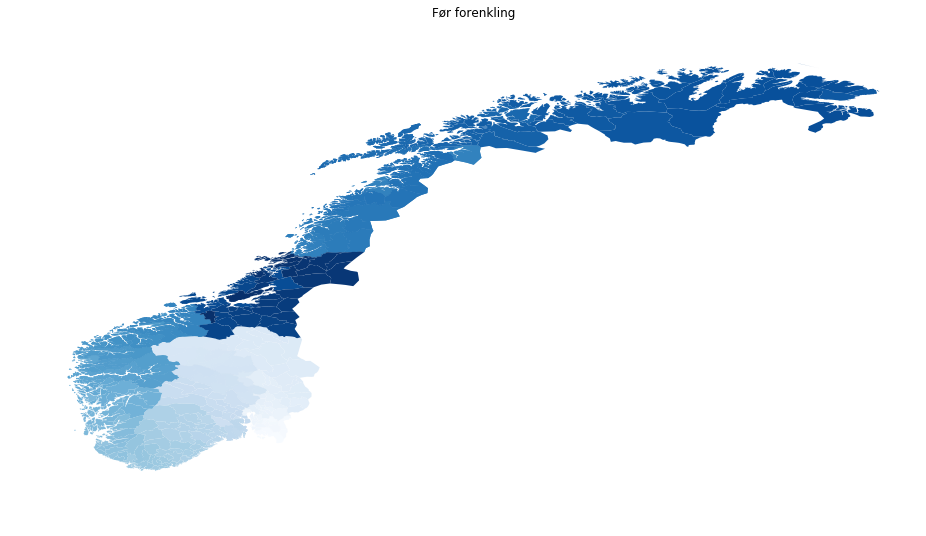

In [82]:
f, ax = plt.subplots(1, figsize=(16, 9))
ax.set_title('Før forenkling')
bg_combgm.plot(column='kommunenummer', cmap=plt.cm.Blues, ax=ax, k=7)
ax.set_axis_off()
plt.axis('equal');

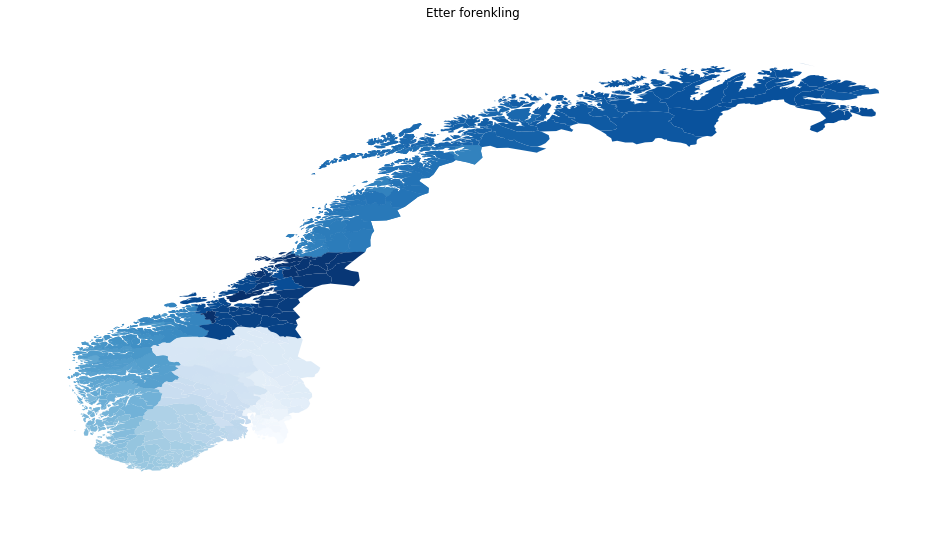

In [83]:
etter = gpd.read_file('data/counties_2018_l_geojson.json')
f, ax = plt.subplots(1, figsize=(16, 9))
ax.set_title('Etter forenkling')
etter.plot(column='kommunenummer', cmap=plt.cm.Blues, ax=ax, k=7)
ax.set_axis_off()
plt.axis('equal');

In [84]:
kart = bg_combgm[['fylke_navn_2019','fylke_nummer_2019','geometry']]
kart = kart.dissolve(by=['fylke_navn_2019','fylke_nummer_2019']).reset_index()
kart['area_fylke'] = kart.area
kart['centroid_fylke'] = kart.centroid

k = json.loads(kart.to_json(cls=jsonEncoder))
path = DATA_LOC + 'fylker_2019_geojson.json'
with open(path, 'w') as fp:
    json.dump(k, fp)
    
simplify('fylker_2019')

['[simplify] Repaired 16 intersections', '[o] Wrote data/fylker_2019_s_geojson.json']
['[simplify] Repaired 18 intersections', '[o] Wrote data/fylker_2019_m_geojson.json']
['[simplify] Repaired 6 intersections', '[o] Wrote data/fylker_2019_l_geojson.json']
['[simplify] Repaired 2 intersections', '[o] Wrote data/fylker_2019_xl_geojson.json']
['[o] Wrote data/fylker_2019_xxl_geojson.json']


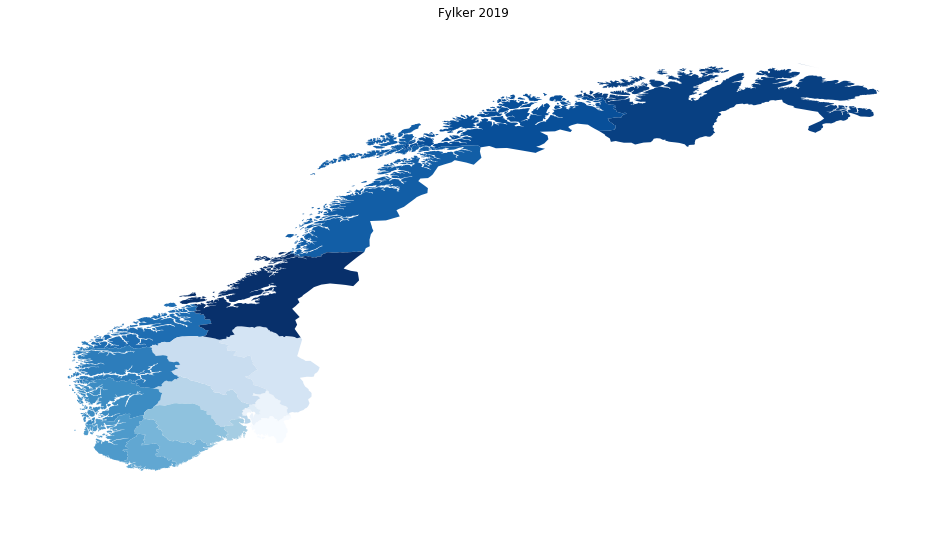

In [85]:
f, ax = plt.subplots(1, figsize=(16, 9))
ax.set_title('Fylker 2019')
kart.plot(column='fylke_nummer_2019', cmap=plt.cm.Blues, ax=ax)
ax.set_axis_off()
plt.axis('equal');

In [117]:
kart = bg_combgm[['fylke_navn_2020','fylke_nummer_2020','geometry']]
kart = kart.dissolve(by=['fylke_navn_2020','fylke_nummer_2020']).reset_index()
kart['area_fylke'] = kart.area
kart['centroid_fylke'] = kart.centroid

k = json.loads(kart.to_json(cls=jsonEncoder))
path = DATA_LOC + 'fylker_2020_geojson.json'
with open(path, 'w') as fp:
    json.dump(k, fp)
    
simplify('fylker_2020')

['[simplify] Repaired 16 intersections', '[o] Wrote data/fylker_2020_s_geojson.json']
['[simplify] Repaired 18 intersections', '[o] Wrote data/fylker_2020_m_geojson.json']
['[simplify] Repaired 6 intersections', '[o] Wrote data/fylker_2020_l_geojson.json']
['[simplify] Repaired 3 intersections', '[o] Wrote data/fylker_2020_xl_geojson.json']
['[o] Wrote data/fylker_2020_xxl_geojson.json']


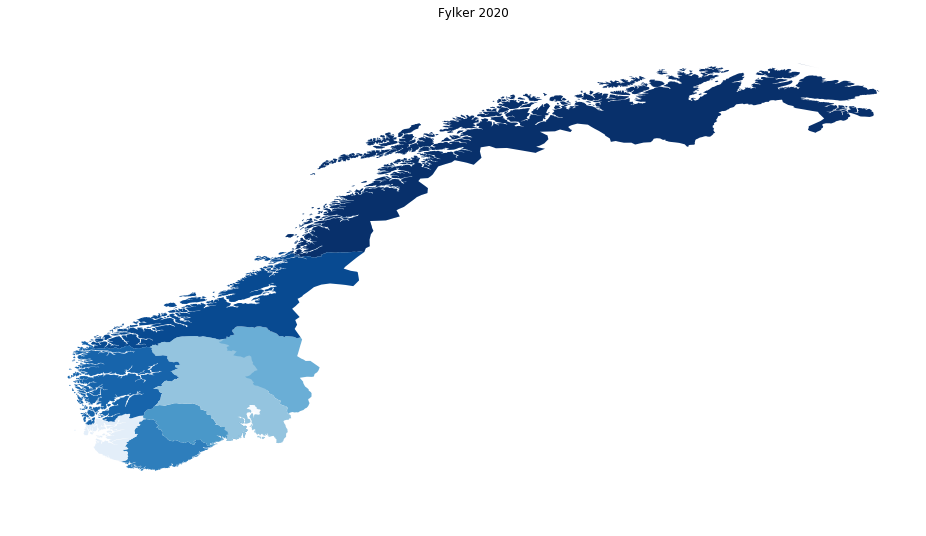

In [118]:
f, ax = plt.subplots(1, figsize=(16, 9))
ax.set_title('Fylker 2020')
kart.plot(column='fylke_nummer_2020', cmap=plt.cm.Blues, ax=ax)
ax.set_axis_off()
plt.axis('equal');

In [120]:
kart.head()

,fylke_navn_2020,fylke_nummer_2020,geometry,area_fylke,centroid_fylke
0,AGDER,42,(POLYGON ((7.529018331616079 58.00040468605124...,2.527201,POINT (7.621109975407564 58.70069334465698)
1,INNLANDET,34,"POLYGON ((10.86473918597175 60.31392492387408,...",8.842876,POINT (10.42730039385681 61.4339035558174)
2,MØRE OG ROMSDAL,15,(POLYGON ((4.742123869544885 61.03140383392254...,5.591119,POINT (7.032096257117177 61.93089449445443)
3,NORDLAND,18,(POLYGON ((12.17935171797339 64.99031628903852...,7.766459,POINT (14.7563472364045 66.92134823109359)
4,OSLO,03,"POLYGON ((10.63605582806944 60.1337519214481, ...",0.072517,POINT (10.74012764750227 59.98206491261678)


In [121]:
bg_combgm.head()

,kommunenummer,oppdateringsdato,navn,geometry,area_kommune,centroid_kommune,fylke_nummer_2018,fylke_nummer_2019,fylke_navn_2019,fylke_nummer_2020,fylke_navn_2020
0,0101,2018-12-10T00:00:00,Halden,"POLYGON ((11.36230711472923 59.25108194016833,...",0.100015,POINT (11.49840476949333 59.08595732263681),01,01,ØSTFOLD,30,VIKEN
1,0104,2018-12-10T00:00:00,Moss,(POLYGON ((10.68526365742154 59.48628146390853...,0.009754,POINT (10.69478548367322 59.45187621919044),01,01,ØSTFOLD,30,VIKEN
2,0105,2018-12-10T00:00:00,Sarpsborg,"POLYGON ((11.12530389689554 59.41688228397493,...",0.063157,POINT (11.16186657442922 59.288044170917),01,01,ØSTFOLD,30,VIKEN
3,0106,2018-12-10T00:00:00,Fredrikstad,"POLYGON ((10.96088236151343 59.32395833688725,...",0.043210,POINT (10.93750665163056 59.23057820000602),01,01,ØSTFOLD,30,VIKEN
4,0111,2018-12-10T00:00:00,Hvaler,(POLYGON ((11.04347482750593 59.08998758279098...,0.010446,POINT (10.96515514632339 59.07160447267584),01,01,ØSTFOLD,30,VIKEN


In [122]:
bg_combgm[bg_combgm['kommunenummer']=='0301']

,kommunenummer,oppdateringsdato,navn,geometry,area_kommune,centroid_kommune,fylke_nummer_2018,fylke_nummer_2019,fylke_navn_2019,fylke_nummer_2020,fylke_navn_2020
40,0301,2018-12-10T00:00:00,Oslo,"POLYGON ((10.63605582806944 60.1337519214481, ...",0.072517,POINT (10.74012764750227 59.98206491261678),03,03,OSLO,03,OSLO


In [123]:
def getFylker(fylke, år):
    kart = bg_combgm[bg_combgm[f'fylke_nummer_{år}']==fylke]

    k = json.loads(kart.to_json(cls=jsonEncoder))
    path = DATA_LOC + f'fylke_{fylke}_{år}_geojson.json'
    with open(path, 'w') as fp:
        json.dump(k, fp)

    simplify(f'fylke_{fylke}_{år}')

In [99]:
fylker_2018 = bg_combgm['fylke_nummer_2018'].unique()
fylker_2018

array(['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11',
       '12', '14', '15', '18', '19', '20', '50'], dtype=object)

In [100]:
fylker_2019 = bg_combgm['fylke_nummer_2019'].unique()
fylker_2019

array(['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11',
       '12', '14', '15', '18', '19', '20', '50'], dtype=object)

In [98]:
fylker_2020 = bg_combgm['fylke_nummer_2020'].unique()
fylker_2020

array(['30', '03', '34', '38', '42', '11', '46', '15', '50', '18', '54'],
      dtype=object)

In [103]:
for fylke in fylker_2018:
    getFylker(fylke,'2018')

['[o] Wrote data/fylke_01_2018_s_geojson.json']
['[o] Wrote data/fylke_01_2018_m_geojson.json']
['[o] Wrote data/fylke_01_2018_l_geojson.json']
['[o] Wrote data/fylke_01_2018_xl_geojson.json']
['[o] Wrote data/fylke_01_2018_xxl_geojson.json']
['[o] Wrote data/fylke_02_2018_s_geojson.json']
['[o] Wrote data/fylke_02_2018_m_geojson.json']
['[o] Wrote data/fylke_02_2018_l_geojson.json']
['[o] Wrote data/fylke_02_2018_xl_geojson.json']
['[o] Wrote data/fylke_02_2018_xxl_geojson.json']
['[o] Wrote data/fylke_03_2018_s_geojson.json']
['[o] Wrote data/fylke_03_2018_m_geojson.json']
['[o] Wrote data/fylke_03_2018_l_geojson.json']
['[o] Wrote data/fylke_03_2018_xl_geojson.json']
['[o] Wrote data/fylke_03_2018_xxl_geojson.json']
['[o] Wrote data/fylke_04_2018_s_geojson.json']
['[o] Wrote data/fylke_04_2018_m_geojson.json']
['[o] Wrote data/fylke_04_2018_l_geojson.json']
['[o] Wrote data/fylke_04_2018_xl_geojson.json']
['[o] Wrote data/fylke_04_2018_xxl_geojson.json']
['[o] Wrote data/fylke_05_20

In [104]:
for fylke in fylker_2019:
    getFylker(fylke,'2019')

['[o] Wrote data/fylke_01_2019_s_geojson.json']
['[o] Wrote data/fylke_01_2019_m_geojson.json']
['[o] Wrote data/fylke_01_2019_l_geojson.json']
['[o] Wrote data/fylke_01_2019_xl_geojson.json']
['[o] Wrote data/fylke_01_2019_xxl_geojson.json']
['[o] Wrote data/fylke_02_2019_s_geojson.json']
['[o] Wrote data/fylke_02_2019_m_geojson.json']
['[o] Wrote data/fylke_02_2019_l_geojson.json']
['[o] Wrote data/fylke_02_2019_xl_geojson.json']
['[o] Wrote data/fylke_02_2019_xxl_geojson.json']
['[o] Wrote data/fylke_03_2019_s_geojson.json']
['[o] Wrote data/fylke_03_2019_m_geojson.json']
['[o] Wrote data/fylke_03_2019_l_geojson.json']
['[o] Wrote data/fylke_03_2019_xl_geojson.json']
['[o] Wrote data/fylke_03_2019_xxl_geojson.json']
['[o] Wrote data/fylke_04_2019_s_geojson.json']
['[o] Wrote data/fylke_04_2019_m_geojson.json']
['[o] Wrote data/fylke_04_2019_l_geojson.json']
['[o] Wrote data/fylke_04_2019_xl_geojson.json']
['[o] Wrote data/fylke_04_2019_xxl_geojson.json']
['[o] Wrote data/fylke_05_20

In [105]:
for fylke in fylker_2020:
    getFylker(fylke,'2020')

['[simplify] Repaired 2 intersections', '[o] Wrote data/fylke_30_2020_s_geojson.json']
['[o] Wrote data/fylke_30_2020_m_geojson.json']
['[o] Wrote data/fylke_30_2020_l_geojson.json']
['[o] Wrote data/fylke_30_2020_xl_geojson.json']
['[o] Wrote data/fylke_30_2020_xxl_geojson.json']
['[o] Wrote data/fylke_03_2020_s_geojson.json']
['[o] Wrote data/fylke_03_2020_m_geojson.json']
['[o] Wrote data/fylke_03_2020_l_geojson.json']
['[o] Wrote data/fylke_03_2020_xl_geojson.json']
['[o] Wrote data/fylke_03_2020_xxl_geojson.json']
['[o] Wrote data/fylke_34_2020_s_geojson.json']
['[o] Wrote data/fylke_34_2020_m_geojson.json']
['[o] Wrote data/fylke_34_2020_l_geojson.json']
['[o] Wrote data/fylke_34_2020_xl_geojson.json']
['[o] Wrote data/fylke_34_2020_xxl_geojson.json']
['[simplify] Repaired 4 intersections', '[o] Wrote data/fylke_38_2020_s_geojson.json']
['[o] Wrote data/fylke_38_2020_m_geojson.json']
['[o] Wrote data/fylke_38_2020_l_geojson.json']
['[o] Wrote data/fylke_38_2020_xl_geojson.json']


In [106]:
def plotkart(kart):
    f, ax = plt.subplots(1, figsize=(16, 9))
    ax.set_title('Fylker 2020')
    kart.plot(column='kommunenummer', cmap=plt.cm.Blues, ax=ax)
    ax.set_axis_off()
    plt.axis('equal');

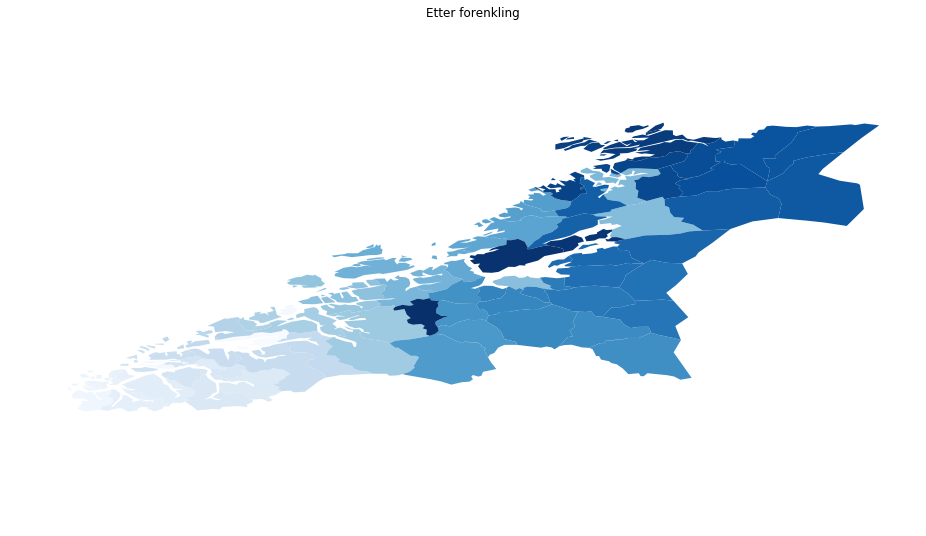

In [109]:
etter = gpd.read_file('data/fylke_50_2020_xl_geojson.json')
f, ax = plt.subplots(1, figsize=(16, 9))
ax.set_title('Etter forenkling')
etter.plot(column='kommunenummer', cmap=plt.cm.Blues, ax=ax, k=7)
ax.set_axis_off()
plt.axis('equal');

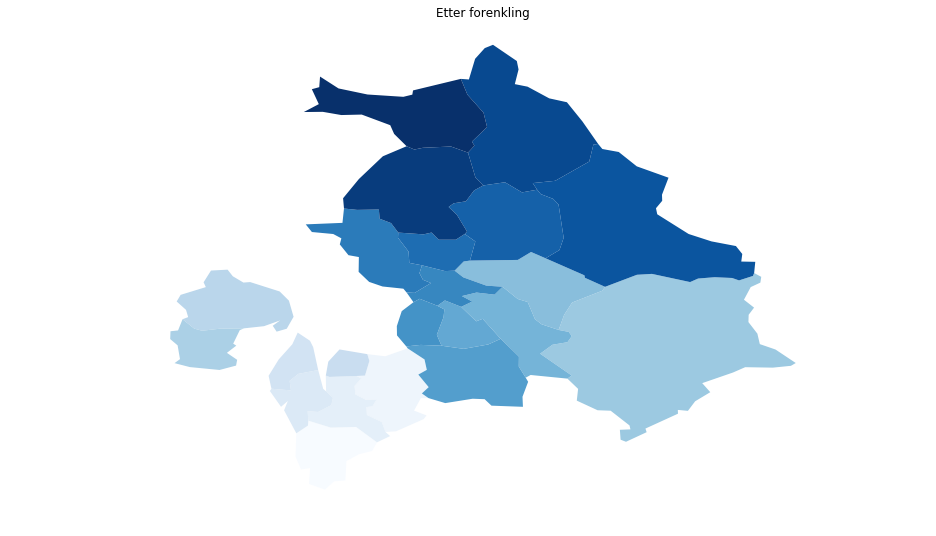

In [110]:
etter = gpd.read_file('data/fylke_02_2019_xl_geojson.json')
f, ax = plt.subplots(1, figsize=(16, 9))
ax.set_title('Etter forenkling')
etter.plot(column='kommunenummer', cmap=plt.cm.Blues, ax=ax, k=7)
ax.set_axis_off()
plt.axis('equal');

# Generate some dummy data

In [111]:
def to_json_file(df, path):
    with open(path, 'w') as fp:
        recs = df.to_json(orient='records')
        json.dump(recs, fp)

In [112]:
import random

def getColor():
    r = int(random.random() * 256) 
    g = int(random.random() * 256) 
    b = int(random.random() * 256) 
    return ([r,g,b]) 

In [113]:
data = []
for k in bg_combgm['kommunenummer'].unique():
    data.append([k, random.randint(1,101), getColor()])
    
df = pd.DataFrame(data)
df.columns = ['kommunenummer', 'value', 'color']
df.to_csv(DATA_LOC + 'kommune_dummy_data.csv', index=False)
to_json_file(df, DATA_LOC + 'kommune_dummy_data.json')

In [114]:
data = []
for k in bg_combgm['fylke_nummer_2018'].unique():
    data.append([k, random.randint(1,101), getColor()])
    
df = pd.DataFrame(data)
df.columns = ['fylke_2018', 'value', 'color']
df.to_csv(DATA_LOC + 'fylke_2019_dummy_data.csv', index=False)
to_json_file(df, DATA_LOC + 'fylke_2019_dummy_data.json')

In [115]:
data = []
for k in bg_combgm['fylke_nummer_2020'].unique():
    data.append([k, random.randint(1,101), getColor()])
    
df = pd.DataFrame(data)
df.columns = ['fylke_nummer_2020', 'value', 'color']
df.to_csv(DATA_LOC + 'fylke_2020_dummy_data.csv', index=False)
to_json_file(df, DATA_LOC + 'fylke_2020_dummy_data.json')

In [116]:
df.to_json(orient='records')

'[{"fylke_nummer_2020":"30","value":33,"color":[59,212,47]},{"fylke_nummer_2020":"03","value":99,"color":[235,33,225]},{"fylke_nummer_2020":"34","value":24,"color":[240,170,192]},{"fylke_nummer_2020":"38","value":2,"color":[137,90,242]},{"fylke_nummer_2020":"42","value":22,"color":[96,212,69]},{"fylke_nummer_2020":"11","value":97,"color":[163,220,166]},{"fylke_nummer_2020":"46","value":24,"color":[139,27,133]},{"fylke_nummer_2020":"15","value":90,"color":[120,30,12]},{"fylke_nummer_2020":"50","value":1,"color":[114,131,219]},{"fylke_nummer_2020":"18","value":22,"color":[75,223,67]},{"fylke_nummer_2020":"54","value":46,"color":[208,220,254]}]'